# Hoshimigato story-to-ML: Quickstart (Colab)

This notebook:
1) loads the dataset
2) exports the per-character *entropy peak band* cut
3) generates plots (event annotations → x1/x2/alpha alongside entropy)
4) runs a vanilla EM/GMM on (x1,x2)


In [60]:
from pathlib import Path
import os, sys

REPO_URL = "https://github.com/Mokafe/reina-field-map.git"
REPO_DIR = Path("/content/reina-field-map")

# ★ここだけ切り替え（基本は sim2 推奨）
PROJECT_SUBDIR = "hoshimigato-shrine-sim2"   # ← sim2
# PROJECT_SUBDIR = "hoshimigato-shrine-sim"  # ← sim

# 1) clone（未cloneなら）: ★clone先を明示
if not REPO_DIR.exists():
    !git clone {REPO_URL} {REPO_DIR}

# 2) cd（プロジェクト直下へ）
PROJECT_DIR = REPO_DIR / PROJECT_SUBDIR
if not PROJECT_DIR.exists():
    raise FileNotFoundError(f"Not found: {PROJECT_DIR} (check PROJECT_SUBDIR)")

os.chdir(PROJECT_DIR)

print("CWD =", Path.cwd())
print("Has requirements.txt?", (PROJECT_DIR / "requirements.txt").exists())
print("Has src/ ?", (PROJECT_DIR / "src").exists())

# 3) import 可能化（src を確実に読む）: ★重複防止
p = str(PROJECT_DIR)
if p not in sys.path:
    sys.path.insert(0, p)

# 4) install: ★絶対パスで指定（CWDズレでも死なない）
!pip -q install -r {PROJECT_DIR/"requirements.txt"}


CWD = /content/reina-field-map/hoshimigato-shrine-sim2
Has requirements.txt? True
Has src/ ? True


In [61]:
# If running in Colab, uncomment the next 2 lines and set your repo URL.
# !git clone https://github.com/Mokafe/reina-field-map.git
# %cd reina-field-map/hoshimigato-shrine-sim

!pip -q install -r requirements.txt


In [62]:
import pandas as pd
from src.io import load_csv
from src.analysis import export_teachcut
from src.plotting import plot_character_bundle
from src.em_gmm import fit_and_plot_gmm_x1x2
from pathlib import Path

df = load_csv('data/hoshike_all_data_en.csv')
df.head()


,t,x1,x2,alpha,z,entropy,character,event,event_en
0,-6,9.242,1.803,3.830,0,0.708,kurokawa,研究推進,Research push
1,-6,9.280,1.875,3.759,-1,0.744,kurokawa,研究推進,Research push
2,-6,9.213,1.854,3.794,0,0.716,kurokawa,研究推進,Research push
3,-6,9.201,1.778,3.827,0,0.701,kurokawa,研究推進,Research push
4,-6,9.323,1.806,3.810,-1,0.738,kurokawa,研究推進,Research push


In [63]:
# Teachcut: only the 'wobble center' (entropy peak band)
out = Path('outputs')
out.mkdir(exist_ok=True)
teachcut_path = export_teachcut(df, out_dir=out/'teachcut', band_half_width=1)
teachcut = pd.read_csv(teachcut_path)
teachcut.groupby('character')['t'].agg(['min','max','count'])


,min,max,count
character,,,
aoi,-1,0,6
kurokawa,-2,-2,8
misaki,-2,-2,3
reina,0,0,7
takumi,-1,0,10
tome,-1,1,6


In [64]:
# Plots: event annotations → x1/x2/alpha alongside entropy + local zoom around entropy peak
meta = plot_character_bundle(df, out_pdf=out/'plots_en.pdf', out_fig_dir=out/'figures', band_half_width=1)
meta


{'aoi': {'t_peak': 0.0, 'band': [-1.0, 1.0], 'n_points': 10},
 'kurokawa': {'t_peak': -2.0, 'band': [-3.0, -1.0], 'n_points': 25},
 'misaki': {'t_peak': -2.0, 'band': [-3.0, -1.0], 'n_points': 25},
 'reina': {'t_peak': 0.0, 'band': [-1.0, 1.0], 'n_points': 20},
 'takumi': {'t_peak': 0.0, 'band': [-1.0, 1.0], 'n_points': 30},
 'tome': {'t_peak': 0.0, 'band': [-1.0, 1.0], 'n_points': 10}}

In [65]:
# EM/GMM overlay
gmm_df = fit_and_plot_gmm_x1x2(df, out_path=out/'figures'/'gmm_overlay_x1x2.png', n_components=6)
gmm_df[['character','gmm_cluster']].value_counts().head(12)


character  gmm_cluster
kurokawa   3              25
takumi     1              25
misaki     0              25
reina      5              13
aoi        2              10
tome       2              10
reina      4               7
takumi     2               4
           4               1
Name: count, dtype: int64

# 1) train/valid/test を優先して読む

In [66]:
from pathlib import Path
import pandas as pd

DATA_DIR = Path("data")

def load_split_or_all(data_dir: Path):
    # 例: data/hoshike_train_en.csv などがある想定
    candidates = {
        "train": ["hoshike_train_en.csv", "hoshike_train_v2.csv", "hoshike_train.csv"],
        "valid": ["hoshike_valid_en.csv", "hoshike_valid_v2.csv", "hoshike_valid.csv"],
        "test":  ["hoshike_test_en.csv",  "hoshike_test_v2.csv",  "hoshike_test.csv"],
        "all":   ["hoshike_all_data_en.csv", "hoshike_all_data_v2.csv", "hoshike_all_data.csv"],
    }

    def pick_first(existing_list):
        for name in existing_list:
            p = data_dir / name
            if p.exists():
                return p
        return None

    p_train = pick_first(candidates["train"])
    p_valid = pick_first(candidates["valid"])
    p_test  = pick_first(candidates["test"])
    p_all   = pick_first(candidates["all"])

    if p_train and p_valid and p_test:
        df_train = pd.read_csv(p_train)
        df_valid = pd.read_csv(p_valid)
        df_test  = pd.read_csv(p_test)
        print("Loaded splits:", p_train.name, p_valid.name, p_test.name)
        return df_train, df_valid, df_test

    if not p_all:
        raise FileNotFoundError("No dataset found under data/.")
    df_all = pd.read_csv(p_all)
    print("Loaded all:", p_all.name, "(no split files found)")
    # splitが無ければ簡易に分ける（教材用）
    df_train = df_all.sample(frac=0.7, random_state=0)
    df_rest  = df_all.drop(df_train.index)
    df_valid = df_rest.sample(frac=0.5, random_state=0)
    df_test  = df_rest.drop(df_valid.index)
    return df_train.reset_index(drop=True), df_valid.reset_index(drop=True), df_test.reset_index(drop=True)

df_train, df_valid, df_test = load_split_or_all(DATA_DIR)
df_train.head()


Loaded splits: hoshike_train_en.csv hoshike_valid_en.csv hoshike_test_en.csv


,t,x1,x2,alpha,z,entropy,character,event,event_en
0,-1,5.162000,5.214000,1.021000,0,0.351000,aoi,同行決意,Decides to go together
1,-4,8.674000,2.344000,2.920000,-1,0.749000,misaki,独白ログ発見,Finds Takumi's log
2,-3,5.263000,6.797000,2.006000,0,0.598000,takumi,陰口を聴く,Overhears gossip
3,-5,5.395000,6.881000,2.106000,0,0.616000,takumi,自主実験開始,Starts independent field experiment
4,-1,4.811913,5.161816,1.037946,0,0.292828,tome,冷めてもいいようにまんじゅうを作る,Makes manju for his return


# 2) 4状態ラベル（state4）を 新設し、教師点（確実な点）だけをアンカーにする

「象限で 0..3」を定義に合わせて作る。
ただし“閾値”は固定値より、まずは 中央値で十分（※教材として説明しやすい）。

In [67]:
import numpy as np

def add_state4(df: pd.DataFrame, x1_col="x1", x2_col="x2", x1_thr=None, x2_thr=None):
    if x1_thr is None:
        x1_thr = float(df[x1_col].median())
    if x2_thr is None:
        x2_thr = float(df[x2_col].median())

    # state4:
    # 0 = high x1, low x2
    # 1 = high x1, high x2
    # 2 = low x1, high x2
    # 3 = low x1, low x2
    x1_high = df[x1_col].values >= x1_thr
    x2_high = df[x2_col].values >= x2_thr

    state4 = np.empty(len(df), dtype=int)
    state4[( x1_high) & (~x2_high)] = 0
    state4[( x1_high) & ( x2_high)] = 1
    state4[(~x1_high) & ( x2_high)] = 2
    state4[(~x1_high) & (~x2_high)] = 3

    df = df.copy()
    df["state4"] = state4
    df["x1_thr"] = x1_thr
    df["x2_thr"] = x2_thr
    return df

def make_teachers(df: pd.DataFrame, margin_q=0.15):
    """
    閾値近辺は曖昧なので教師にしない、というルール。
    margin_q=0.15 なら、中央値±(IQRの一部)くらいを“曖昧帯”として弾くイメージ。
    """
    x1 = df["x1"].values
    x2 = df["x2"].values
    x1_thr = float(df["x1_thr"].iloc[0])
    x2_thr = float(df["x2_thr"].iloc[0])

    # 閾値からの距離が小さい点を「曖昧」として除外
    x1_margin = np.quantile(np.abs(x1 - x1_thr), 1 - margin_q)
    x2_margin = np.quantile(np.abs(x2 - x2_thr), 1 - margin_q)

    confident = (np.abs(x1 - x1_thr) >= x1_margin) & (np.abs(x2 - x2_thr) >= x2_margin)

    y = np.full(len(df), -1, dtype=int)
    y[confident] = df["state4"].values[confident]
    return y, confident

df_train2 = add_state4(df_train)
df_valid2 = add_state4(df_valid, x1_thr=df_train2["x1_thr"].iloc[0], x2_thr=df_train2["x2_thr"].iloc[0])
df_test2  = add_state4(df_test,  x1_thr=df_train2["x1_thr"].iloc[0], x2_thr=df_train2["x2_thr"].iloc[0])

y_train, train_confident = make_teachers(df_train2, margin_q=0.15)
print("Teacher ratio (train):", train_confident.mean())


Teacher ratio (train): 0.10416666666666667


# 3) 半教師ありEMを追加（最小・安定版）

In [68]:
import numpy as np

def logsumexp(a, axis=None, keepdims=False):
    a_max = np.max(a, axis=axis, keepdims=True)
    out = a_max + np.log(np.sum(np.exp(a - a_max), axis=axis, keepdims=True))
    if not keepdims:
        out = np.squeeze(out, axis=axis)
    return out

def gaussian_logpdf(X, mean, cov):
    d = X.shape[1]
    # 安定化
    sign, logdet = np.linalg.slogdet(cov)
    if sign <= 0:
        # あり得るのでさらに安定化
        cov = cov + 1e-6 * np.eye(d)
        sign, logdet = np.linalg.slogdet(cov)

    diff = X - mean
    sol = np.linalg.solve(cov, diff.T).T  # (n,d)
    quad = np.sum(diff * sol, axis=1)     # (n,)
    return -0.5 * (d*np.log(2*np.pi) + logdet + quad)

def semisupervised_gmm_em(
    X, y, K=4, max_iter=60, eps_cov=1e-6,
    alpha0=0.5, alpha_max=15.0
):
    """
    y: -1(未ラベル) or 0..K-1(教師)
    alpha: 教師圧（スケジュール：初期弱く→後半強く）
    """
    n, d = X.shape
    rng = np.random.default_rng(0)

    # 初期化：K個をランダムに平均として選ぶ
    mu = X[rng.choice(n, K, replace=False)].copy()
    cov = np.array([np.cov(X.T) + eps_cov*np.eye(d) for _ in range(K)])
    pi = np.full(K, 1.0/K)

    labeled = (y >= 0)

    for it in range(max_iter):
        # alpha schedule
        alpha = alpha0 + (alpha_max - alpha0) * (it / max(1, max_iter-1))

        # E-step: log responsibility
        log_r = np.zeros((n, K))
        for k in range(K):
            log_r[:, k] = np.log(pi[k] + 1e-12) + gaussian_logpdf(X, mu[k], cov[k])

        # 教師点：正解クラスタを“押す”
        # ここはgmm9の「教師点がアンカー」の最小表現
        if labeled.any():
            # それ以外のクラスタを相対的に下げる（= 正解が上がる）
            # hard-fixにしない（alphaで強さ調整）
            for k in range(K):
                mask = labeled & (y == k)
                log_r[mask, k] += alpha

        log_norm = logsumexp(log_r, axis=1, keepdims=True)
        r = np.exp(log_r - log_norm)  # (n,K)

        # M-step
        Nk = r.sum(axis=0) + 1e-12
        pi = Nk / n
        mu = (r.T @ X) / Nk[:, None]

        for k in range(K):
            diff = X - mu[k]
            cov_k = (r[:, k][:, None] * diff).T @ diff / Nk[k]
            cov[k] = cov_k + eps_cov * np.eye(d)

    return {"pi": pi, "mu": mu, "cov": cov}

def gmm_predict(X, params):
    K = len(params["pi"])
    log_r = np.zeros((X.shape[0], K))
    for k in range(K):
        log_r[:, k] = np.log(params["pi"][k] + 1e-12) + gaussian_logpdf(X, params["mu"][k], params["cov"][k])
    return np.argmax(log_r, axis=1), logsumexp(log_r, axis=1)

# 実行：x1,x2 だけ（教材の核）
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(df_train2[["x1","x2"]].values)
X_valid = scaler.transform(df_valid2[["x1","x2"]].values)
X_test  = scaler.transform(df_test2[["x1","x2"]].values)

params = semisupervised_gmm_em(X_train, y_train, K=4, max_iter=60)

pred_train, ll_train = gmm_predict(X_train, params)
pred_valid, ll_valid = gmm_predict(X_valid, params)
pred_test,  ll_test  = gmm_predict(X_test,  params)

print("Avg log-likelihood:")
print("  train:", float(np.mean(ll_train)))
print("  valid:", float(np.mean(ll_valid)))
print("  test :", float(np.mean(ll_test)))




Avg log-likelihood:
  train: -0.4450374729971003
  valid: -0.24147688381997295
  test : -1.0347805517553534


# 4) outputs を確実に生成・保存するセル（PDF/PNG/CSV）

In [69]:
from pathlib import Path

OUT = Path("outputs")
(OUT / "figures").mkdir(parents=True, exist_ok=True)
(OUT / "teachcut").mkdir(parents=True, exist_ok=True)

# 1) teachcut（例：entropy最大の±1）
df_all = pd.concat([df_train2, df_valid2, df_test2], ignore_index=True)
idx_peak = df_all.groupby("character")["entropy"].idxmax()
peak_rows = df_all.loc[idx_peak, ["character", "t", "entropy"]].rename(columns={"t":"t_peak", "entropy":"entropy_peak"})

df_peak_band = []
for _, row in peak_rows.iterrows():
    ch = row["character"]
    t0 = row["t_peak"]
    band = df_all[(df_all["character"]==ch) & (df_all["t"].between(t0-1, t0+1))]
    df_peak_band.append(band)
df_peak_band = pd.concat(df_peak_band, ignore_index=True)
df_peak_band.to_csv(OUT/"teachcut/teachcut_peak_band.csv", index=False)

print("Wrote:", OUT/"teachcut/teachcut_peak_band.csv")

# 2) gmm overlay（簡易プロット）
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(df_train2["x1"], df_train2["x2"], s=10, alpha=0.6, label="train")
plt.scatter(df_valid2["x1"], df_valid2["x2"], s=10, alpha=0.6, label="valid")
plt.scatter(df_test2["x1"],  df_test2["x2"],  s=10, alpha=0.6, label="test")
plt.xlabel("x1"); plt.ylabel("x2"); plt.title("x1-x2 scatter (splits)")
plt.legend()
plt.savefig(OUT/"figures/gmm_overlay_x1x2.png", dpi=160, bbox_inches="tight")
plt.close()

print("Wrote:", OUT/"figures/gmm_overlay_x1x2.png")

# 3) plots_en.pdf は「既存の src.plotting があるならそれを呼ぶ」のが正道
# ここでは notebook から scripts/run_all.py を叩く方が確実（= READMEと一致）
!PYTHONPATH=$PWD python scripts/run_all.py --data data/hoshike_all_data_en.csv

print("Check:", OUT/"plots_en.pdf")


Wrote: outputs/teachcut/teachcut_peak_band.csv
Wrote: outputs/figures/gmm_overlay_x1x2.png
Teacher ratio (train): 0.5

Avg log-likelihood:
  train: -1.8274673991809744
  valid: -2.2314056521287897
  test : -1.7266157441537295

Wrote: /content/reina-field-map/hoshimigato-shrine-sim2/outputs/teachcut/teachcut_peak_band.csv
Wrote: /content/reina-field-map/hoshimigato-shrine-sim2/outputs/figures/gmm_overlay_x1x2.png
Wrote: /content/reina-field-map/hoshimigato-shrine-sim2/outputs/plots_en.pdf
Check: outputs/plots_en.pdf


Wrote: outputs/teachcut/teachcut_peak_band.csv
Wrote: outputs/figures/gmm_overlay_x1x2.png
Teacher ratio (train): 0.5

Avg log-likelihood:
  train: -1.8274673991809744
  valid: -2.2314056521287897
  test : -1.7266157441537295

Wrote: /content/reina-field-map/hoshimigato-shrine-sim2/outputs/teachcut/teachcut_peak_band.csv
Wrote: /content/reina-field-map/hoshimigato-shrine-sim2/outputs/figures/gmm_overlay_x1x2.png
Wrote: /content/reina-field-map/hoshimigato-shrine-sim2/outputs/plots_en.pdf
Check: outputs/plots_en.pdf


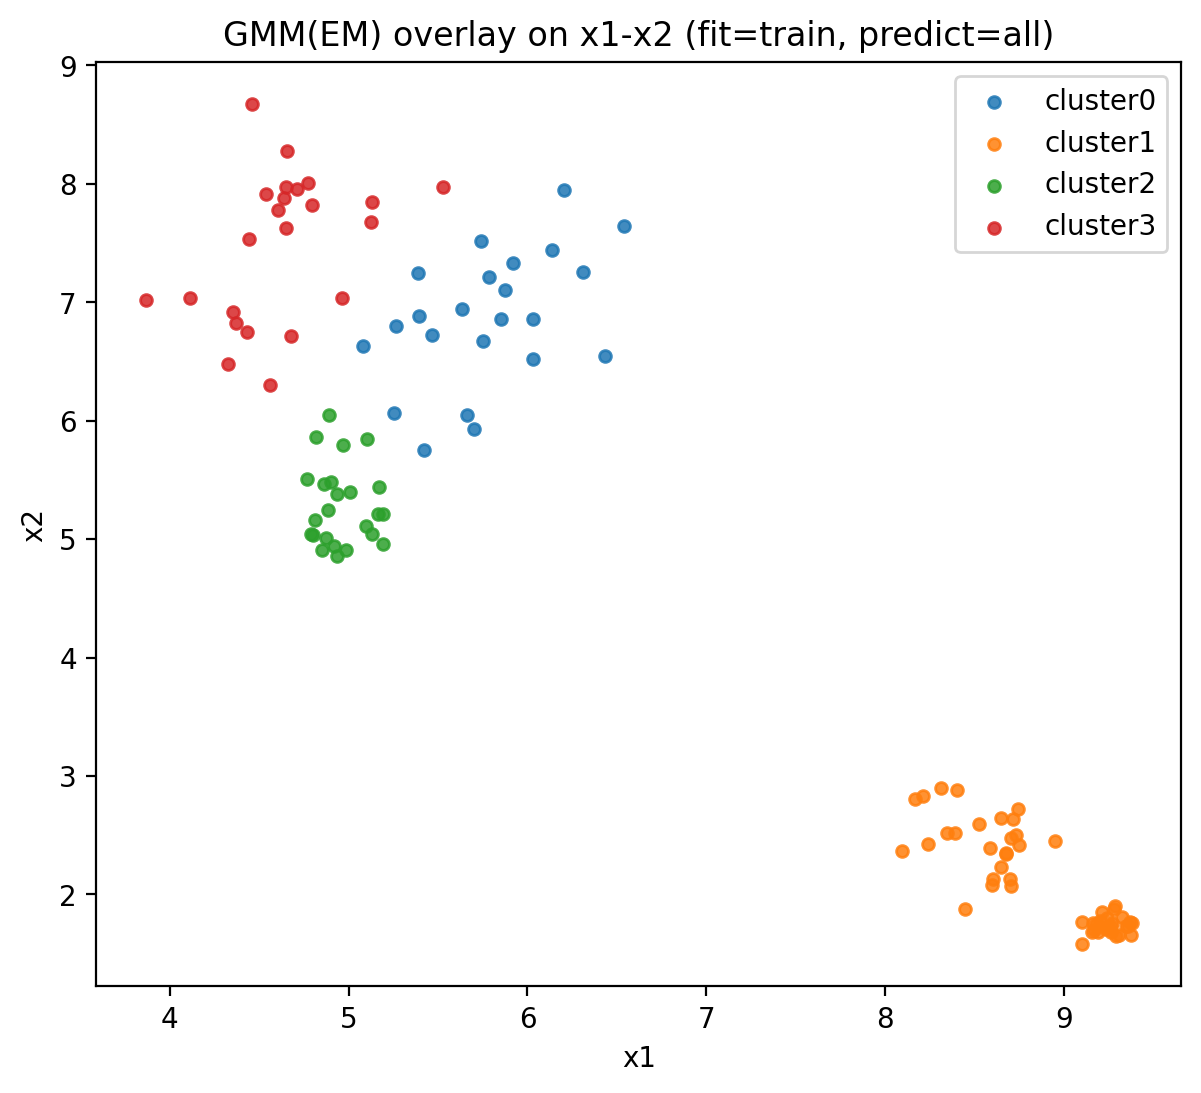

,t,x1,x2,alpha,z,entropy,character,event,event_en,t_peak
0,-1,5.162,5.214,1.021,0,0.351,aoi,同行決意,Decides to go together,0
1,-1,5.129,5.040,0.952,0,0.241,aoi,同行決意,Decides to go together,0
2,-1,5.098,5.107,0.981,0,0.267,aoi,同行決意,Decides to go together,0
3,0,4.861,5.467,0.986,0,0.471,aoi,現実側支援,Support from the real side,0
4,0,5.006,5.395,0.968,0,0.390,aoi,現実側支援,Support from the real side,0
5,0,4.882,5.244,1.028,0,0.353,aoi,現実側支援,Support from the real side,0
6,2,9.098,1.577,3.726,-1,0.822,kurokawa,破綻兆候,Signs of breakdown,2
7,2,9.190,1.681,3.721,-1,0.737,kurokawa,破綻兆候,Signs of breakdown,2
8,2,9.157,1.681,3.737,-1,0.750,kurokawa,破綻兆候,Signs of breakdown,2
9,2,9.100,1.763,3.663,0,0.716,kurokawa,破綻兆候,Signs of breakdown,2


In [70]:
from pathlib import Path
import pandas as pd

OUT = Path("outputs")
(OUT / "figures").mkdir(parents=True, exist_ok=True)
(OUT / "teachcut").mkdir(parents=True, exist_ok=True)

# --- ここは df_train2 / df_valid2 / df_test2 が既にある前提 ---
# もし無い場合は、先にあなたの分割コード（train/valid/test作る部分）を実行してください。

# 1) teachcut（例：entropy最大の±1）
df_all = pd.concat([df_train2, df_valid2, df_test2], ignore_index=True)

idx_peak = df_all.groupby("character")["entropy"].idxmax()
peak_rows = df_all.loc[idx_peak, ["character", "t", "entropy"]].rename(
    columns={"t": "t_peak", "entropy": "entropy_peak"}
)

df_peak_band = []
for _, row in peak_rows.iterrows():
    ch = row["character"]
    t0 = row["t_peak"]
    band = df_all[(df_all["character"] == ch) & (df_all["t"].between(t0 - 1, t0 + 1))]
    df_peak_band.append(band)

df_peak_band = pd.concat(df_peak_band, ignore_index=True)
teachcut_path = OUT / "teachcut/teachcut_peak_band.csv"
df_peak_band.to_csv(teachcut_path, index=False)
print("Wrote:", teachcut_path)

# 2) gmm overlay（簡易プロット）
import matplotlib.pyplot as plt

# ★図自体を小さめに作る（保存されるPNGも小さめになりやすい）
plt.figure(figsize=(5.5, 4.0), dpi=120)

plt.scatter(df_train2["x1"], df_train2["x2"], s=10, alpha=0.6, label="train")
plt.scatter(df_valid2["x1"], df_valid2["x2"], s=10, alpha=0.6, label="valid")
plt.scatter(df_test2["x1"],  df_test2["x2"],  s=10, alpha=0.6, label="test")

plt.xlabel("x1")
plt.ylabel("x2")
plt.title("x1-x2 scatter (splits)")
plt.legend()
plt.tight_layout()

png_path = OUT / "figures/gmm_overlay_x1x2.png"
plt.savefig(png_path, dpi=120, bbox_inches="tight")
plt.close()
print("Wrote:", png_path)

# 3) scripts/run_all.py を確実に動かす（src が見えるように PYTHONPATH を付ける）
#    ※run_all.py の中でも outputs/plots_en.pdf を作ろうとしますが、
#      PDFの「表示」はここではやりません（Colabで拒否されやすいので）。
!PYTHONPATH=$PWD python scripts/run_all.py --data data/hoshike_all_data_en.csv

print("Check:", OUT/"plots_en.pdf")  # 生成されているかだけ確認用

# 4) Colab上で「小さく」表示（PNGとCSVの中身だけ）
from IPython.display import display, Image

if png_path.exists():
    # ★ここで表示サイズを調整（数値を小さくするとさらに小さく表示）
    display(Image(filename=str(png_path), width=520))

if teachcut_path.exists():
    display(pd.read_csv(teachcut_path).head(10))
